# Exploring prediction markets
> I want to explore some ideas about making bets

- toc: true 
- badges: true
- comments: true
- categories: [prediction markets, betting]

# Alice and Bob bets on the election

Alice and Bob are rational agents with their own current beliefs about whether Mr. T. will win the election. Mr. T. will either win or not, and so they view it as a Bernoulli variable $X$. Truly $X \sim \text{Ber}(\theta_{true})$.

Alice and Bob both have point estimates about the probability. They are $\theta_{a}$ and $\theta_{b}$ respectively, and therefore their beliefs are represented by their belief distributions $p_{a}(x) = \text{Ber}(x; \theta_{a})$ and $p_{b}(x) = \text{Ber}(x; \theta_{b})$.

How can Alice and Bob set up a bet they are both satisfied with?

# How do we split the pot?

The first idea Alice and Bob have is the following: They both put 50 cent in a pot, so now there is 1 dollar in the pot. When the election is over Alice and Bob will be honest with each about who truly won the election, so after the outcome of $X$ is revealed there will be no dispute.

How will they split the pot? Their first idea is the following. A gets fraction $f_a$ of the outcome,

$$
f_b(x) = \frac{p_a(x)}{p_a(x) + p_b(x)}
$$

Then *given* that A has belief $p_a$, A should expect to win
$$
\mathbb{E}_{x \sim p_a}[f_a(x)] = \theta_a \frac{\theta_a}{\theta_a + \theta_b} + (1-\theta_a) \frac{1 - \theta_a}{(1-\theta_a) + (1-\theta_b)}
$$

Likewise B expects $\mathbb{E}_{x \sim p_b}[f_b]$. Making a rule that $\theta_a$ and $\theta_b$ should be in the open interval $(0,1)$ - no absolute certainty - is sufficient condition for this expectation being defined, since then there is no division by zero. Also, only a Sith deals in absolutes.

If instead of just two players and two outcomes, there are $M$ players and $K$ outcomes (a categorical variable), then an equivalent rule for how much each player $m$ should get would be
$$
f_m(k) = \frac{p_m(k)}{\sum_{i=1}^{M} p_i(k)}
$$
and player $m$ would expect to win
$$\mathbb{E}_{k \sim p_m}[f_m(k)] = \sum_{k=1}p_m(k) f_m(k) = \sum_{k=1} p_m(k) \frac{p_m(k)}{\sum_{i=1}^{M} p_i(k)}$$

We could call $\mathbb{E}_{k \sim p_m}[f_m(k)]$ the "open self-expected prize" for player $m$ and denote it $Z_m$. It is "open" because it is a function of all the probabilities, so Alice would only be able to compute it if she knew the probabilities of all the others. It is "self-expected" because Alice computes the expectation with respect to her own beliefs about the outcome.

# Would Alice and Bob participate in such a bet?

If the $m$ players contribute an equal amount to the pot, then the fraction of the pot they will have at stake is $\frac{1}{M}$ dollars. Alice realized the same thing, that she expects to win $Z_a$. She is willing to participate in the bet if she does not expect to win less than what she has at stake. That means, a player $m$ is willing to participate if
$$
Z_m \geq \frac{1}{M}
$$

For finite number of agents $M$ and finite number of outcomes $K$, this inequality always holds. See [this MathOverflow post](https://mathoverflow.net/questions/416333/inequality-for-matrix-with-rows-summing-to-1). Thanks Federico Poloni and Iosif Pinelis!

Intuitively this tells us, that no matter what Bob thought, Alice would be able to compute $Z_a$ and come out in favor of participating in the bet. Likewise would Bob.

# Bob says his belief, now Alice wants to lie!

Let's say that Bob told Alice that his belief was $\theta_b = .3$. Assume that truly Alice has belief $\theta_a = .5$.
We can view all of this as a matrix $P$ showing the belief.

In [1]:
#collapse_hide
import torch
P = torch.tensor([
    [.5,.5],
    [.7,.3]
])
print('P:',P)

P: tensor([[0.5000, 0.5000],
        [0.7000, 0.3000]])


Then $Z_m$ is computed as follows

In [2]:
def Z(m,P):
    return P[m] @ (P[m] / P.sum(dim=0))

Alice and Bob have exactly the same $Z$. For more players than two, this will not be the case.

In [3]:
#collapse_hide
print('Z_a : ', Z(0,P).item())
print('Z_b : ', Z(1,P).item())

Z_a :  0.5208333134651184
Z_b :  0.5208333134651184


But we just said that Bob said his belief first, so now the question is - would Alice want to lie about her beliefs in order to win more? To think about this we have to distinguish between the belief-distribution and the commit-distribution. For now we assume that players never change their real beliefs about the outcome, but they might present a different distribution:

We write $q_a = \text{Ber}(\theta'_a)$ to denote the distribution with which Alice participates in the bet, so she will get

$$f'_a(x) = \frac{q_a(x)}{q_a(x) + q_b(x)}$$

With this change we can look at what a player $m$ expects to win $W_m = \mathbb{E}_{x \sim p_m}[f'_m(x)]$. The expectation is with respect to what the player truly belives about what will happen, but the public distribution $q_m(x)$ is what is used to compute the fraction. 

In [123]:
def W(m,P,Q):
    #P[m] @ (Q[m] / (Q.sum(dim=0)
    return P[m] @ (Q[m] / ((Q.sum(dim=0) - Q[m]).detach() + Q[m]))

What if Alice chose to lie, and say that her belief is $.49$ instead of $.5$? Then her self-expectation $W_a > Z_a$, she would be better off by being dishonest:

In [124]:
#collapse_hide
import torch
#qap = 0.99999
Q = torch.tensor([
    [.51,.49],
    [.7,.3]
])
print('Q:', Q)
print('W_a : ', W(0,P,Q).item())
print('W_b : ', W(1,P,Q).item())
print('Alice is better off lying:',  (W(0,P,Q) > Z(0,P)).item())

Q: tensor([[0.5100, 0.4900],
        [0.7000, 0.3000]])
W_a :  0.5208703279495239
W_b :  0.5188827514648438
Alice is better off lying: True


Notice that while the $Z$ vector is public, known by all players, the $W_m$ is only known by player $m$.

In [125]:
#collapse_hide
qaps = torch.linspace(0,1,1000)
was = torch.zeros_like(qaps)
for i, qap in enumerate(qaps):
    Q = torch.tensor([
        [1-qap,qap],
        [.7,.3]
    ])
    was[i] = W(0,P,Q).item()
    
argmax_wa = was.argmax()
print('Optimal thing to tell Bob', qaps[argmax_wa].item())
print('Maximum W_a', was[argmax_wa].item())

Optimal thing to tell Bob 0.49149149656295776
Maximum W_a 0.5208711624145508


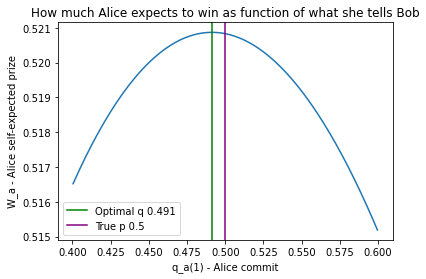

In [126]:
#collapse_hide
import matplotlib.pyplot as plt
plt.plot(qaps[400:600],was[400:600])
plt.xlabel("q_a(1) - Alice commit")
plt.ylabel('W_a - Alice self-expected prize')
plt.title('How much Alice expects to win as function of what she tells Bob')
plt.axvline(x=qaps[argmax_wa], label='Optimal q ' + str(round(qaps[argmax_wa].item(),3)), c='Green') #label='Maximum ' + str(round(was[argmax_wa].item(),3)), c='Green')
plt.axvline(x=0.5, label='True p ' + str(0.5), c='Purple') 
plt.legend()

# Future work

* What if Alice and Bob takes rounds? Will they converge to something, possibly converging to being honest?

In [127]:
P

tensor([[0.5000, 0.5000],
        [0.7000, 0.3000]])

In [128]:
Q

tensor([[0.0000, 1.0000],
        [0.7000, 0.3000]])

In [129]:
W(0,P,Q)

tensor(0.3846)

In [130]:
def get_optimal_lie(actor,P,opponent_commit, make_plot=False):
    opponent = 1 - actor
    #collapse_hide
    qaps = torch.linspace(0,1,1000)
    was = torch.zeros_like(qaps)
    for i, qap in enumerate(qaps):
        Q = torch.zeros(2,2)
        Q[actor] = torch.tensor([1-qap,qap])
        Q[opponent] = torch.tensor([1-opponent_commit,opponent_commit])
        was[i] = W(actor,P,Q).item()
        #print(qap.item(), was[i].item())

    argmax_wa = was.argmax()
    if make_plot:
        print('Optimal thing to tell Bob', qaps[argmax_wa].item())
        print('Maximum W_a', was[argmax_wa].item())
    lie = qaps[argmax_wa].item()
    
    if make_plot:
        plt.plot(qaps,was)
        plt.xlabel("q_a(1) - Alice commit")
        plt.ylabel('W_m - Self-expected prize')
        plt.title('How much actor expects to win as function of what she tells opponent')
        plt.axvline(x=qaps[argmax_wa], label='Optimal q ' + str(round(qaps[argmax_wa].item(),3)), c='Green') #label='Maximum ' + str(round(was[argmax_wa].item(),3)), c='Green')
        plt.axvline(x=0.5, label='True p ' + str(P[actor,1].item()), c='Purple') 
        plt.legend()
        plt.show()
        
    return lie

Optimal thing to tell Bob 0.49149149656295776
Maximum W_a 0.5208711624145508


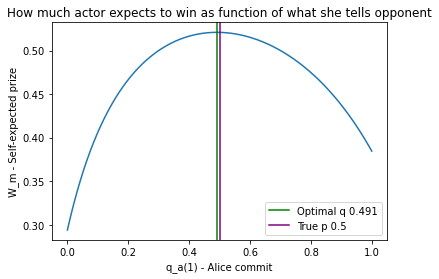

0.49149149656295776

In [131]:
get_optimal_lie(0,P,0.3,make_plot=True)

Optimal thing to tell Bob 0.2912912964820862
Maximum W_a 0.5208711624145508


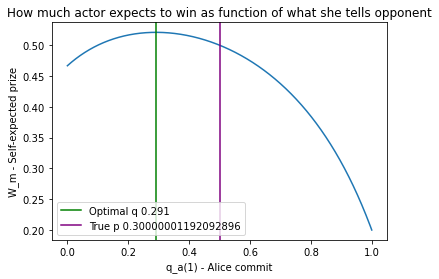

0.2912912964820862

In [132]:
get_optimal_lie(1,P,0.5,make_plot=True)

In [133]:
commit_a = 0.5
commit_b = 0.3
n_rounds = 10
for i in range(n_rounds):
    print('Round', i+1)
    commit_a_new = get_optimal_lie(0,P,commit_b)
    print('A changes to: ', commit_a_new)
    commit_b_new = get_optimal_lie(1,P,commit_a_new)
    print('B changes to: ', commit_b_new)
    if commit_a == commit_a_new and commit_b_new == commit_b_new:
        print('Converged at round', i)
        break
    commit_a = commit_a_new
    commit_b = commit_b_new

Round 1
A changes to:  0.49149149656295776
B changes to:  0.2912912964820862
Round 2
A changes to:  0.49049049615859985
B changes to:  0.2912912964820862
Round 3
A changes to:  0.49049049615859985
B changes to:  0.2912912964820862
Converged at round 2


In [134]:
commit_a = 0.5
commit_b = 0.3
n_rounds = 10
for i in range(n_rounds):
    print('Round', i+1)
    commit_b_new = get_optimal_lie(1,P,commit_a)
    print('B changes to: ', commit_b_new)
    commit_a_new = get_optimal_lie(0,P,commit_b_new)
    print('A changes to: ', commit_a_new)
    if commit_a == commit_a_new and commit_b_new == commit_b_new:
        print('Converged at round', i)
        break
    commit_a = commit_a_new
    commit_b = commit_b_new

Round 1
B changes to:  0.2912912964820862
A changes to:  0.49049049615859985
Round 2
B changes to:  0.2912912964820862
A changes to:  0.49049049615859985
Converged at round 1


1. We see that when A begins, the convergence is in round 2
2. When B begins, the convergence is in round 1
3. No matter who starts we converge to the same state
4. The system does not converge to being honest.

In [135]:
commit_a = 0.9
commit_b = 0.1
n_rounds = 10
for i in range(n_rounds):
    print('Round', i+1)
    commit_a_new = get_optimal_lie(0,P,commit_b)
    print('A changes to: ', commit_a_new)
    commit_b_new = get_optimal_lie(1,P,commit_a)
    print('B changes to: ', commit_b_new)
    if commit_a == commit_a_new and commit_b_new == commit_b_new:
        print('Converged at round', i)
        break
    commit_a = commit_a_new
    commit_b = commit_b_new

Round 1
A changes to:  0.40040040016174316
B changes to:  0.4254254102706909
Round 2
A changes to:  0.49949949979782104
B changes to:  0.29629629850387573
Round 3
A changes to:  0.49049049615859985
B changes to:  0.2912912964820862
Round 4
A changes to:  0.49049049615859985
B changes to:  0.2912912964820862
Converged at round 3


While truth-telling would be more desirable, if we cannot find a setup that makes the players truth-telling, then we could still be interested in knowing how close the converged commitments are to the beliefs.

In [169]:
import torch.nn.functional as F
from torch.optim import SGD
import torch.nn as nn

In [170]:
bigP_pre = torch.randn(10,15)
bigP = F.softmax(bigP_pre,dim=1)

In [171]:
bigQ_pre = nn.Parameter(bigP_pre)
bigQ = F.softmax(bigQ_pre,dim=1)

In [172]:
yo = nn.ParameterList([bigQ_pre])

In [173]:
optimizer = SGD(yo, lr=1)

In [174]:
bigQ_original = torch.clone(bigQ_pre)
bigQ_original

tensor([[-1.6987,  0.8528, -0.7843, -0.4358, -0.5387,  0.3704,  0.7336,  0.9321,
         -0.7919,  0.1487,  1.5875,  1.3028,  0.3905, -1.8477, -0.5827],
        [ 0.6563,  0.1248,  0.1381,  1.4480,  0.2306, -1.1111, -0.3087,  0.1005,
          1.4946,  0.8601, -1.1095,  0.7682,  0.8997,  0.6234,  1.1169],
        [ 0.7795, -0.2566, -0.5283,  0.3141,  0.7228,  1.1433, -0.1439,  1.1063,
         -0.7016,  1.8334,  0.1200, -0.4502,  0.3000, -1.2136, -0.0275],
        [ 0.1186,  0.3005,  0.1473,  1.7827,  0.2945, -0.2025, -0.1494, -0.5049,
          0.6935, -0.3597,  2.8083,  0.9526, -0.8212, -0.7851, -2.4008],
        [ 1.3455,  0.8825,  0.3052,  1.1806,  0.6407, -0.2624,  1.4298, -1.0216,
          0.9604,  1.1862,  0.1980, -0.9984,  1.0989, -0.3872, -0.8436],
        [-1.1524, -0.7704,  1.5180,  1.3983,  1.3659, -0.4575, -0.8256,  1.0604,
          0.6914,  0.7781,  0.3320, -1.4219,  0.6834, -0.3403, -0.0289],
        [ 1.2176, -0.3952, -1.2409, -2.1911, -1.3631, -0.1861, -2.0966,  1.0

In [175]:
history = []
for i in range(10000):
    optimizer.zero_grad()
    loss = -W(9,bigP,F.softmax(bigQ_pre,dim=1))
    loss.backward()
    optimizer.step()
    val = 15 * -loss.item()
    print(val)
    history.append(val)

2.1176909655332565
2.1200381219387054
2.122366949915886
2.12467722594738
2.1269696205854416
2.1292436867952347
2.1314994245767593
2.1337370574474335
2.135957032442093
2.138158679008484
2.1403424441814423
2.1425089985132217
2.144657224416733
2.146787792444229
2.1489009261131287
2.1509961783885956
2.1530739963054657
2.155134603381157
2.1571777760982513
2.1592039614915848
2.1612124890089035
2.163204252719879
2.1651792526245117
2.1671370416879654
2.169078066945076
2.1710023283958435
2.172909826040268
2.174801230430603
2.176676094532013
2.1785346418619156
2.180376872420311
2.182203009724617
2.184012606739998
2.185807451605797
2.1875857561826706
2.189348414540291
2.1910954266786575
2.1928267925977707
2.194543182849884
2.196243926882744
2.1979303658008575
2.199600711464882
2.2012565284967422
2.202897146344185
2.2045232355594635
2.206135019659996
2.2077318280935287
2.209314778447151
2.2108834236860275
2.212437093257904
2.213977575302124
2.2155041992664337
2.2170165181159973
2.2185152024030685


2.4157802760601044
2.415868118405342
2.415955737233162
2.41604246199131
2.416129410266876
2.4162159115076065
2.416302412748337
2.4163882434368134
2.41647407412529
2.4165594577789307
2.416645511984825
2.416730225086212
2.416814938187599
2.416899651288986
2.4169839173555374
2.4170681834220886
2.417152225971222
2.4172353744506836
2.417318969964981
2.4174021184444427
2.4174852669239044
2.4175679683685303
2.4176499992609024
2.4177324771881104
2.4178145080804825
2.4178965389728546
2.417977675795555
2.4180590361356735
2.418140396475792
2.4182210862636566
2.4183017760515213
2.418382242321968
2.418462485074997
2.41854228079319
2.418621852993965
2.4187014251947403
2.4187805503606796
2.418859675526619
2.4189388006925583
2.419017478823662
2.4190954864025116
2.419174388051033
2.419251948595047
2.419329285621643
2.419407293200493
2.419484630227089
2.419561743736267
2.4196384102106094
2.4197153002023697
2.419791743159294
2.4198681861162186
2.4199437350034714
2.42001973092556
2.420095056295395
2.42017

2.443743199110031
2.443768233060837
2.4437928199768066
2.4438176304101944
2.443842440843582
2.443866580724716
2.443891167640686
2.443915754556656
2.4439403414726257
2.4439651519060135
2.4439892917871475
2.4440134316682816
2.4440377950668335
2.4440621584653854
2.4440865218639374
2.4441111087799072
2.4441350251436234
2.4441593885421753
2.4441837519407272
2.4442076683044434
2.4442320317029953
2.4442555010318756
2.4442798644304276
2.4443035572767258
2.444327473640442
2.444351390004158
2.444375306367874
2.4443992227315903
2.4444231390953064
2.4444470554590225
2.444470524787903
2.444494217634201
2.444518357515335
2.4445416033267975
2.444564625620842
2.444588765501976
2.4446124583482742
2.4446357041597366
2.444659173488617
2.4446826428174973
2.4447058886289597
2.44472935795784
2.4447526037693024
2.4447760730981827
2.4447988718748093
2.4448223412036896
2.444845363497734
2.4448688328266144
2.444891408085823
2.4449148774147034
2.4449381232261658
2.4449611455202103
2.444983944296837
2.44500696659

2.4529610574245453
2.452974244952202
2.452988103032112
2.4530012905597687
2.453014925122261
2.4530281126499176
2.45304174721241
2.4530551582574844
2.453068569302559
2.4530817568302155
2.453094944357872
2.4531083554029465
2.453121319413185
2.4531349539756775
2.4531476944684982
2.4531613290309906
2.453174516558647
2.4531877040863037
2.4532008916139603
2.4532143026590347
2.4532274901866913
2.453240677714348
2.4532538652420044
2.453266829252243
2.4532800167798996
2.453293204307556
2.4533068388700485
2.453320026397705
2.453332766890526
2.4533457309007645
2.453358694911003
2.4533721059560776
2.453385293483734
2.453398033976555
2.4534109979867935
2.4534237384796143
2.453436926007271
2.4534498900175095
2.453463077545166
2.453475594520569
2.4534890055656433
2.453501746058464
2.4535147100687027
2.4535278975963593
2.453540414571762
2.4535536020994186
2.4535661190748215
2.453578859567642
2.4535920470952988
2.4536052346229553
2.4536175280809402
2.453630715608597
2.4536432325839996
2.453655973076820

2.459195628762245
2.4592038989067078
2.4592123925685883
2.459220215678215
2.4592284858226776
2.45923675596714
2.4592452496290207
2.4592530727386475
2.45926134288311
2.4592696130275726
2.459277883172035
2.45928592979908
2.4592937529087067
2.459302470088005
2.459310069680214
2.4593187868595123
2.459326386451721
2.4593348801136017
2.4593429267406464
2.459350973367691
2.4593594670295715
2.4593670666217804
2.459375336766243
2.4593831598758698
2.459391877055168
2.459399700164795
2.4594077467918396
2.4594157934188843
2.459423840045929
2.4594318866729736
2.4594399333000183
2.459447979927063
2.4594558030366898
2.4594640731811523
2.459472343325615
2.4594803899526596
2.4594882130622864
2.459496259689331
2.459504082798958
2.4595121294260025
2.459520176053047
2.459528222680092
2.4595362693071365
2.459544315934181
2.459552139043808
2.4595601856708527
2.4595680087804794
2.459576055407524
2.459584102034569
2.4595917016267776
2.4595997482538223
2.459607794880867
2.4596156179904938
2.4596234411001205
2.

2.463165521621704
2.4631713330745697
2.4631769210100174
2.463182285428047
2.463188096880913
2.4631939083337784
2.463199272751808
2.463204860687256
2.4632106721401215
2.4632158130407333
2.463221624493599
2.463226765394211
2.4632323533296585
2.4632377177476883
2.463243082165718
2.463248446583748
2.4632544815540314
2.4632596224546432
2.463265210390091
2.4632707983255386
2.4632763862609863
2.463281974196434
2.463287338614464
2.4632929265499115
2.4632982909679413
2.463303878903389
2.463309019804001
2.4633146077394485
2.4633201956748962
2.463325783610344
2.463330924510956
2.4633365124464035
2.4633416533470154
2.463347688317299
2.4633530527353287
2.4633581936359406
2.4633637815713882
2.463369369506836
2.4633747339248657
2.4633798748254776
2.4633852392435074
2.463391050696373
2.4633966386318207
2.4634017795324326
2.4634071439504623
2.463412508368492
2.46341809630394
2.4634234607219696
2.4634288251399994
2.463434189558029
2.463439553976059
2.4634449183940887
2.4634505063295364
2.463455647230148

2.465992793440819
2.4659961462020874
2.4660003930330276
2.466004192829132
2.4660079926252365
2.466012015938759
2.466016039252281
2.4660196155309677
2.46602363884449
2.4660272151231766
2.466031461954117
2.4660352617502213
2.4660390615463257
2.46604286134243
2.4660466611385345
2.466050237417221
2.4660544842481613
2.4660582840442657
2.466062307357788
2.466065436601639
2.466069906949997
2.4660734832286835
2.466077506542206
2.466081529855728
2.4660851061344147
2.466088905930519
2.4660924822092056
2.46609628200531
2.4661005288362503
2.4661043286323547
2.466108128428459
2.466111481189728
2.46611550450325
2.4661190807819366
2.466123104095459
2.4661271274089813
2.4661309272050858
2.4661342799663544
2.4661383032798767
2.4661418795585632
2.4661459028720856
2.466149926185608
2.4661535024642944
2.466157302260399
2.4661611020565033
2.4661649018526077
2.4661684781312943
2.4661722779273987
2.466176301240921
2.4661803245544434
2.46618390083313
2.466187924146652
2.466191053390503
2.4661950767040253
2.46

2.4675603210926056
2.467563673853874
2.467567026615143
2.4675699323415756
2.4675730615854263
2.467575967311859
2.46757909655571
2.4675817787647247
2.4675849080085754
2.467588037252426
2.4675913900136948
2.4675942957401276
2.4675974249839783
2.467600107192993
2.467603236436844
2.4676063656806946
2.4676092714071274
2.46761217713356
2.467615306377411
2.4676184356212616
2.4676213413476944
2.467624470591545
2.467627599835396
2.4676302820444107
2.4676336348056793
2.467636540532112
2.467639669775963
2.4676423519849777
2.4676454812288284
2.4676483869552612
2.467651069164276
2.4676544219255447
2.4676573276519775
2.467660680413246
2.467663362622261
2.4676664918661118
2.4676693975925446
2.4676723033189774
2.46767520904541
2.4676787853240967
2.4676816910505295
2.4676841497421265
2.467687726020813
2.46769018471241
2.4676935374736786
2.4676964432001114
2.467699572443962
2.467702478170395
2.4677058309316635
2.4677080661058426
2.4677111953496933
2.467714101076126
2.4677174538373947
2.4677205830812454


2.4689816683530807
2.4689841270446777
2.468986362218857
2.468988597393036
2.468990832567215
2.46899351477623
2.468995749950409
2.468998208642006
2.469000220298767
2.469002902507782
2.469005137681961
2.469007819890976
2.469009831547737
2.46901273727417
2.469014748930931
2.469017431139946
2.469019442796707
2.469021901488304
2.469024360179901
2.469026818871498
2.469029054045677
2.4690312892198563
2.4690337479114532
2.469036430120468
2.469038888812065
2.4690406769514084
2.469043582677841
2.4690458178520203
2.4690480530261993
2.4690502882003784
2.4690525233745575
2.4690549820661545
2.4690574407577515
2.4690592288970947
2.4690616875886917
2.4690641462802887
2.4690668284893036
2.4690695106983185
2.4690715223550797
2.4690737575292587
2.4690766632556915
2.469078451395035
2.4690811336040497
2.4690833687782288
2.46908538043499
2.469088062644005
2.469090297818184
2.469092085957527
2.469094544649124
2.469097226858139
2.469099462032318
2.469101920723915
2.469104155898094
2.469106614589691
2.46910862

2.470284104347229
2.47028611600399
2.4702879041433334
2.4702899158000946
2.470291703939438
2.4702930450439453
2.4702952802181244
2.4702970683574677
2.470298632979393
2.470300644636154
2.4703028798103333
2.4703046679496765
2.470306232571602
2.470308244228363
2.470310479402542
2.4703122675418854
2.470313608646393
2.470315396785736
2.470317631959915
2.4703191965818405
2.4703212082386017
2.470322996377945
2.470324784517288
2.4703265726566315
2.4703283607959747
2.470330372452736
2.470332384109497
2.4703341722488403
2.4703359603881836
2.4703381955623627
2.4703390896320343
2.4703413248062134
2.4703431129455566
2.4703449010849
2.470346912741661
2.4703487008810043
2.470350041985512
2.470352277159691
2.470354288816452
2.4703558534383774
2.4703576415777206
2.470359429717064
2.470361441373825
2.4703632295131683
2.4703652411699295
2.4703672528266907
2.470368593931198
2.4703703820705414
2.4703723937273026
2.470374181866646
2.470375970005989
2.4703775346279144
2.4703799933195114
2.470381334424019
2.4

2.47125081717968
2.471252828836441
2.4712541699409485
2.471255734562874
2.4712570756673813
2.4712584167718887
2.471259981393814
2.4712617695331573
2.4712633341550827
2.4712644517421722
2.4712660163640976
2.471267804503441
2.471269592642784
2.4712707102298737
2.471272274851799
2.4712738394737244
2.4712754040956497
2.471276745200157
2.4712783098220825
2.471279427409172
2.471281662583351
2.4712830036878586
2.471284121274948
2.4712856858968735
2.471286803483963
2.4712885916233063
2.4712901562452316
2.471291497349739
2.4712930619716644
2.47129462659359
2.4712959676980972
2.4712975323200226
2.47129887342453
2.4713006615638733
2.4713020026683807
2.471303790807724
2.4713049083948135
2.471306473016739
2.4713080376386642
2.4713096022605896
2.471311166882515
2.4713127315044403
2.4713142961263657
2.4713151901960373
2.4713169783353806
2.471318319439888
2.4713198840618134
2.4713216722011566
2.471322789788246
2.4713245779275894
2.471325919032097
2.4713272601366043
2.4713290482759476
2.471329942345619

2.472023516893387
2.4720248579978943
2.472025752067566
2.4720273166894913
2.472028434276581
2.4720297753810883
2.472030892968178
2.472032457590103
2.472033351659775
2.4720349162817
2.4720358103513718
2.472037151455879
2.4720387160778046
2.472039610147476
2.4720409512519836
2.472042292356491
2.4720436334609985
2.472044751048088
2.4720458686351776
2.472047433257103
2.4720483273267746
2.472049668431282
2.4720505625009537
2.4720527976751328
2.4720534682273865
2.4720552563667297
2.4720559269189835
2.4720577150583267
2.4720583856105804
2.4720603972673416
2.4720612913370132
2.472062408924103
2.4720637500286102
2.4720648676156998
2.4720659852027893
2.472067102789879
2.4720684438943863
2.4720700085163116
2.472071126103401
2.4720722436904907
2.4720733612775803
2.4720747023820877
2.472076043486595
2.4720771610736847
2.472078502178192
2.4720796197652817
2.472081184387207
2.4720820784568787
2.472083643078804
2.4720845371484756
2.472086101770401
2.4720867723226547
2.472088560461998
2.472089678049087

2.472682446241379
2.4726833403110504
2.47268445789814
2.4726855754852295
2.472686469554901
2.4726878106594086
2.472688928246498
2.4726900458335876
2.4726909399032593
2.472691833972931
2.4726927280426025
2.472693622112274
2.4726954102516174
2.472696080803871
2.4726974219083786
2.472698539495468
2.4726996570825577
2.4727005511522293
2.472701445221901
2.4727027863264084
2.47270368039608
2.4727047979831696
2.472705915570259
2.472706586122513
2.4727079272270203
2.472708821296692
2.4727099388837814
2.472710832953453
2.4727121740579605
2.47271329164505
2.4727141857147217
2.472715303301811
2.472716197371483
2.4727173149585724
2.472718432545662
2.4727199971675873
2.472720667719841
2.4727217853069305
2.472722679376602
2.472723573446274
2.4727249145507812
2.472725585103035
2.4727271497249603
2.472727820277214
2.4727291613817215
2.472730278968811
2.4727313965559006
2.47273251414299
2.4727334082126617
2.4727345257997513
2.472735419869423
2.4727365374565125
2.4727369844913483
2.4727387726306915
2.47

2.473275437951088
2.4732765555381775
2.4732770025730133
2.473277896642685
2.4732792377471924
2.473279908299446
2.4732810258865356
2.473282143473625
2.473282814025879
2.4732834845781326
2.473284602165222
2.473285272717476
2.4732868373394012
2.473287284374237
2.4732881784439087
2.4732892960309982
2.473289966583252
2.4732908606529236
2.473291754722595
2.4732930958271027
2.4732939898967743
2.473294660449028
2.4732953310012817
2.473296895623207
2.473297119140625
2.4732982367277145
2.473299354314804
2.473300024867058
2.4733011424541473
2.473301813006401
2.473302483558655
2.4733038246631622
2.473304495215416
2.4733056128025055
2.473306283354759
2.473307177424431
2.4733080714941025
2.473309189081192
2.4733100831508636
2.4733109772205353
2.473311424255371
2.4733125418424606
2.473313882946968
2.473314329981804
2.4733156710863113
2.473316118121147
2.4733172357082367
2.4733181297779083
2.473319247364998
2.4733199179172516
2.473320811986923
2.473321482539177
2.4733226001262665
2.473323494195938
2.4

2.473760023713112
2.4737606942653656
2.473761811852455
2.4737627059221268
2.4737629294395447
2.4737638235092163
2.473764941096306
2.4737651646137238
2.473766952753067
2.473767399787903
2.4737678468227386
2.4737685173749924
2.4737698584795
2.4737705290317535
2.4737711995840073
2.4737725406885147
2.4737729877233505
2.4737736582756042
2.473774328827858
2.4737752228975296
2.4737756699323654
2.473777011036873
2.4737776815891266
2.4737783521413803
2.473779246211052
2.4737801402807236
2.4737805873155594
2.473781704902649
2.4737825989723206
2.4737828224897385
2.473783940076828
2.4737852811813354
2.4737855046987534
2.473785951733589
2.4737870693206787
2.4737872928380966
2.473788410425186
2.4737895280122757
2.4737901985645294
2.473791092634201
2.4737919867038727
2.4737926572561264
2.47379332780838
2.4737942218780518
2.4737948924303055
2.473795562982559
2.4737966805696487
2.4737975746393204
2.473798021674156
2.473798915743828
2.4738000333309174
2.473800480365753
2.473801374435425
2.47380226850509

2.4741916358470917
2.4741920828819275
2.474193200469017
2.4741938710212708
2.4741945415735245
2.474195212125778
2.474195882678032
2.4741963297128677
2.4741974472999573
2.474198341369629
2.4741987884044647
2.4741996824741364
2.4741999059915543
2.474200576543808
2.4742012470960617
2.4742019176483154
2.474203258752823
2.4742037057876587
2.4742043763399124
2.4742048233747482
2.4742059409618378
2.4742061644792557
2.4742068350315094
2.474207505583763
2.4742086231708527
2.4742095172405243
2.474209740757942
2.474210411310196
2.4742110818624496
2.4742119759321213
2.474212646484375
2.4742135405540466
2.4742139875888824
2.474214658141136
2.4742157757282257
2.4742159992456436
2.4742166697978973
2.474217563867569
2.4742184579372406
2.4742189049720764
2.47421957552433
2.474220246076584
2.4742211401462555
2.474221810698509
2.474222257733345
2.4742233753204346
2.4742238223552704
2.474224492907524
2.474225163459778
2.4742260575294495
2.4742260575294495
2.474227175116539
2.4742282927036285
2.47422851622

2.474566027522087
2.474566251039505
2.4745671451091766
2.4745675921440125
2.474568486213684
2.474569156765938
2.4745693802833557
2.4745702743530273
2.474571168422699
2.474571391940117
2.4745725095272064
2.4745729565620422
2.474573403596878
2.4745740741491318
2.4745747447013855
2.4745751917362213
2.474576085805893
2.4745765328407288
2.4745769798755646
2.4745776504278183
2.47457854449749
2.4745789915323257
2.4745801091194153
2.474580332636833
2.4745814502239227
2.4745816737413406
2.4745818972587585
2.474583238363266
2.474583461880684
2.4745843559503555
2.4745845794677734
2.474585473537445
2.474585920572281
2.4745865911245346
2.4745870381593704
2.474587708711624
2.4745888262987137
2.4745888262987137
2.4745899438858032
2.474590390920639
2.474590837955475
2.4745912849903107
2.4745919555425644
2.474592626094818
2.4745935201644897
2.4745939671993256
2.4745944142341614
2.474595308303833
2.4745959788560867
2.4745964258909225
2.4745970964431763
2.474597990512848
2.4745986610651016
2.474598884582

2.4749095737934113
2.474910244345665
2.4749111384153366
2.4749115854501724
2.474912256002426
2.474912703037262
2.4749133735895157
2.4749138206243515
2.4749142676591873
2.474914714694023
2.4749158322811127
2.4749158322811127
2.4749167263507843
2.47491717338562
2.474917843937874
2.4749180674552917
2.474919408559799
2.474919408559799
2.474919632077217
2.474920302629471
2.4749211966991425
2.474922090768814
2.474922314286232
2.474922761321068
2.4749234318733215
2.474924325942993
2.474924549460411
2.474924772977829
2.4749256670475006
2.4749261140823364
2.474927008152008
2.474927455186844
2.4749279022216797
2.4749283492565155
2.474929243326187
2.474929243326187
2.4749303609132767
2.4749308079481125
2.4749310314655304
2.474931702017784
2.474932372570038
2.4749328196048737
2.4749337136745453
2.474934160709381
2.474934384226799
2.4749352782964706
2.4749357253313065
2.47493639588356
2.474936619400978
2.4749375134706497
2.4749379605054855
2.4749386310577393
2.474939078092575
2.474939748644829
2.47

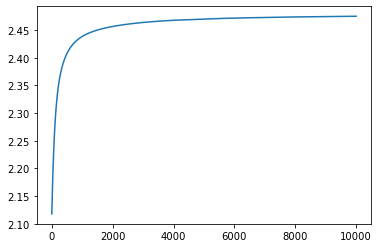

In [176]:
plt.plot(history)

In [179]:
F.softmax(bigQ_pre,dim=1)[9]

tensor([0.2678, 0.0005, 0.0008, 0.2694, 0.0020, 0.1464, 0.0006, 0.0218, 0.0003,
        0.0007, 0.0006, 0.2259, 0.0620, 0.0006, 0.0006],
       grad_fn=<SelectBackward0>)

In [180]:
F.softmax(bigQ_original,dim=1)[9]

tensor([0.1491, 0.0191, 0.0263, 0.1627, 0.0550, 0.1045, 0.0225, 0.1102, 0.0058,
        0.0523, 0.0526, 0.1189, 0.0808, 0.0166, 0.0235],
       grad_fn=<SelectBackward0>)

In [181]:
bigP[9]

tensor([0.1491, 0.0191, 0.0263, 0.1627, 0.0550, 0.1045, 0.0225, 0.1102, 0.0058,
        0.0523, 0.0526, 0.1189, 0.0808, 0.0166, 0.0235])

In [177]:
bigQ_pre - bigQ_original 

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0